# WeRateDogs Twitter Data Wrangling & Analysis

## Table of Contents

- <a href='#intro'>Introduction</a>
- <a href='#gather'>Gather</a>
- <a href='#assess'>Assess</a>
- <a href='#clean'>Clean</a>
- <a href='#store'>Store</a>
- <a href='#analysis'>Exploratory Data Analysis</a>
- <a href='#conclusion'>Conclusion</a>
- <a href='#sources'>Sources</a>

<a id='intro'></a>
## Introduction

WeRateDogs is a Twitter account that posts and rates pictures of dogs. These ratings often are not serious and have numerators that are greater than the denominators. In this analysis, I will mostly focus on wrangling WeRateDogs's Twitter archive through August 1, 2017. Most of the necessary Twitter data has been provided by Udacity and includes information on each post, as well as details on each dog such as the name, rating, and stage (whether the dog is a doggo, floofer, pupper, or puppo). See below for definitions on the dog stages. However, not all of the desired data is present in Udacity's dataset, so I will also use the Twitter API to gather additional data.

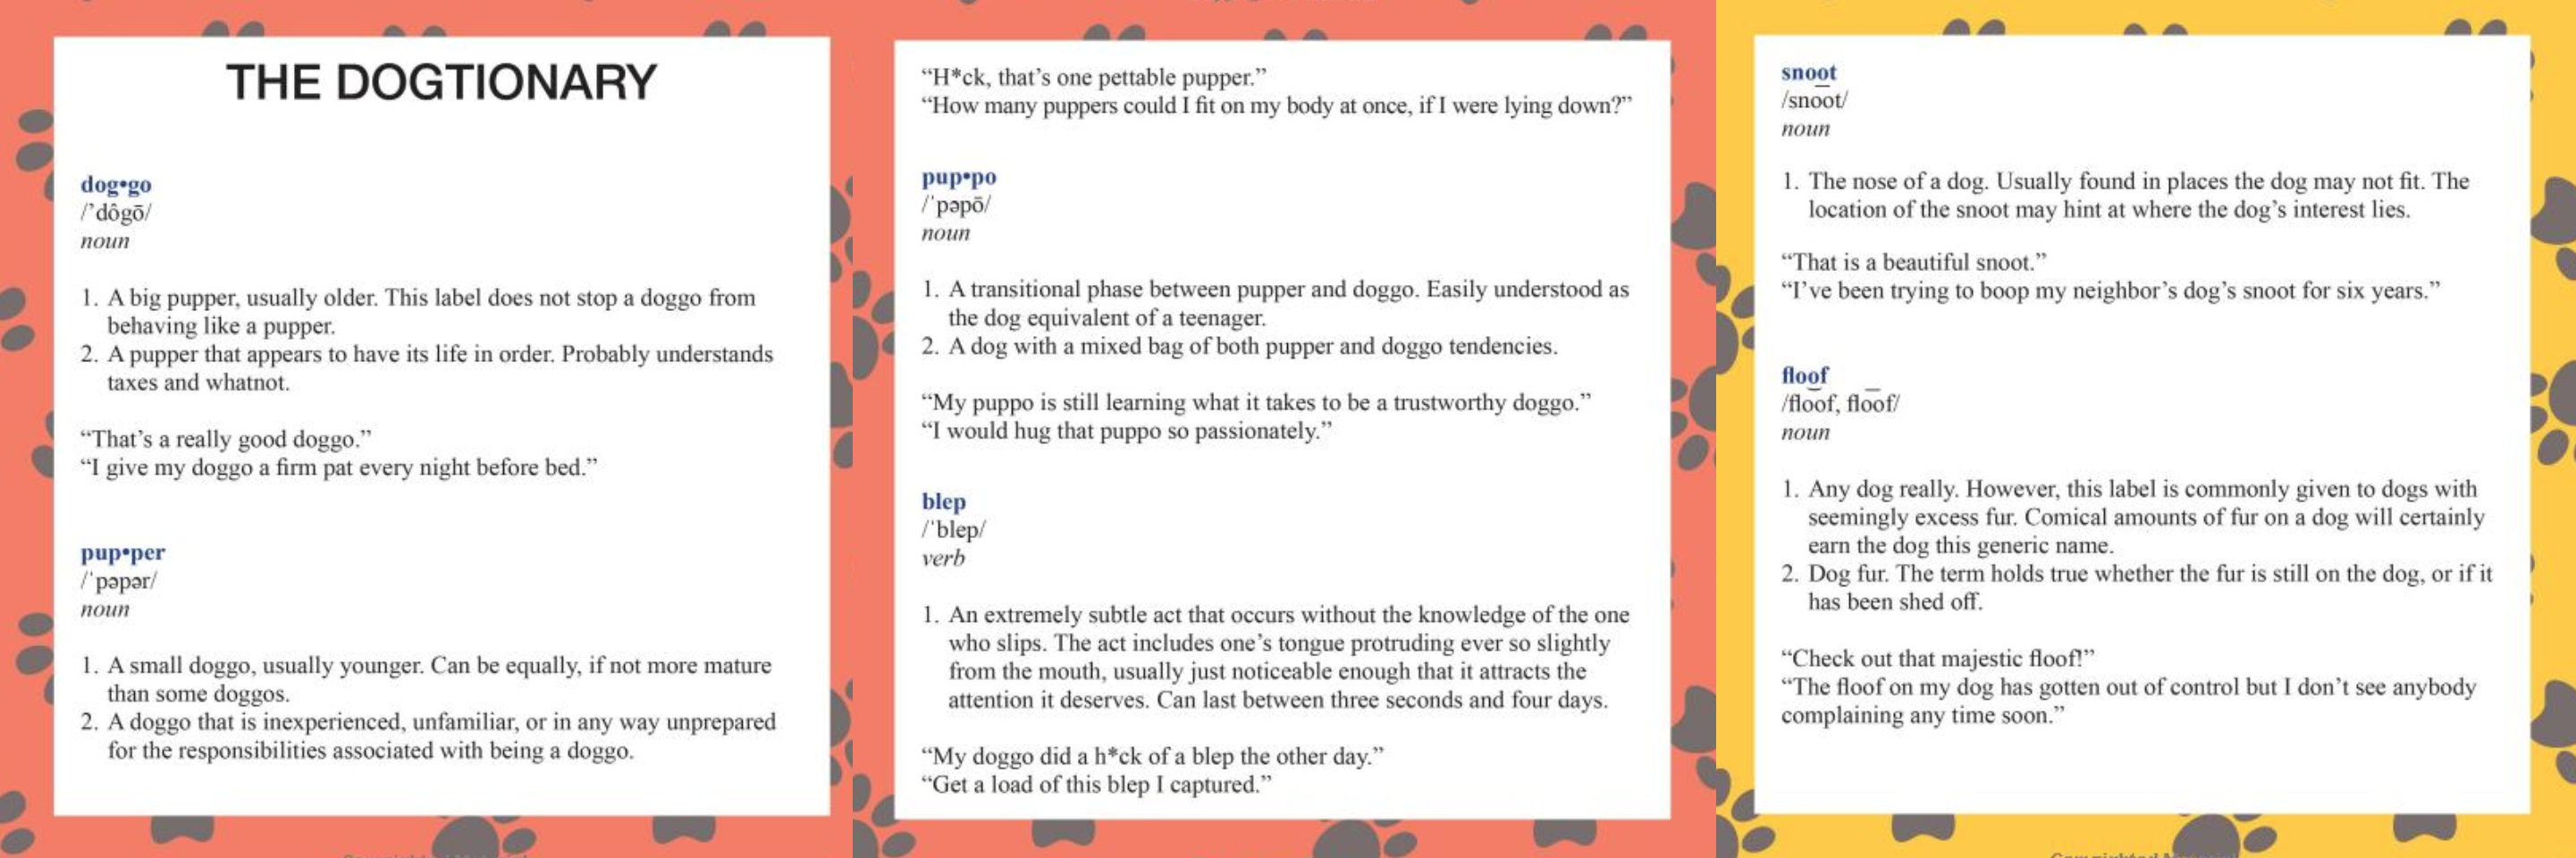

In addition, Udacity ran the images on WeRateDogs's account through a neural network to generate three predictions for each image. For each prediction, there is also data on the confidence and whether the prediction is a type of dog breed.

In the data wrangling process, I will only focus on original tweets by WeRateDogs that have ratings and images. At the end, I will also provide a brief analysis using the cleaned data. In the analysis, I will aim to answer the following questions:

- What is WeRateDogs's posting trend by month?
- What is the monthly trend of interactions with WeRateDogs's posts?
- What are the most popular dog breeds based on number of posts, interactions by Twitter users, and ratings?
- Is there any correlation between WeRateDogs's ratings and the interactions by Twitter users?

To begin the data wrangling process, I will import the necessary packages and also change the limit on the maximum column width.

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
pd.set_option('display.max_colwidth', None)

<a id='gather'></a>
## Gather

First, I downloaded the Twitter archive from Udacity and will read it into a dataframe.

In [2]:
archive = pd.read_csv('twitter-archive-enhanced.csv')

The second dataset, which has the image predictions, is located at a URL provided by Udacity. I will use this URL to download the data and read it into a dataframe programatically.

In [3]:
# image predictions URL provided by Udacity
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(r.content)

In [4]:
predictions = pd.read_csv('image-predictions.tsv', sep='\t')

The Twitter archive provided by Udacity does not have all of the desired data, specifically retweet and favorite counts. I will use the Twitter API to read each tweet's JSON data into its own line in a TXT file. Then I will read this file line by line to create a dataframe with retweet and favorite counts. Some of the tweets provided by Udacity may have been deleted, so I will also keep track of this. Note that the `consumer_key`, `consumer_secret`, `access_token`, and `access_secret` have been deleted here.

In [5]:
# the following confidential data has been replaced by generic strings
consumer_key = 'CONSUMER_KEY'
consumer_secret = 'CONSUMER_SECRET'
access_token = 'ACCESS_TOKEN'
access_secret = 'ACCESS_SECRET'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# keep track of tweets provided by Udacity that have been deleted
failed_tweet = []
with open('tweet_json.txt', mode='w', encoding='utf-8') as file:
    for tweet_id in archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            tweet_json = json.dumps(tweet._json)
            # write tweet JSON data line by line
            file.write(tweet_json + '\n')
        except:
            failed_tweet.append(tweet_id)

In [7]:
df_list = []
with open('tweet_json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    # read tweet JSON data line by line
    for line in lines:
        data = json.loads(line)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        df_list.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})
tweet_data = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

<a id='assess'></a>
## Assess

Now that the data is gathered, I will assess it to see what cleaning I will have to do. First I will perform a visual assessment.

In [8]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [9]:
predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [10]:
tweet_data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7548,35703
1,892177421306343426,5593,30867
2,891815181378084864,3704,23208
3,891689557279858688,7722,38983
4,891327558926688256,8332,37231
...,...,...,...
2326,666049248165822465,40,96
2327,666044226329800704,126,266
2328,666033412701032449,39,111
2329,666029285002620928,41,120


Here are my observations after visually assessing the dataframes.

`archive`: This dataframe is not tidy, specifically with the dog stages. Rather than having a separate column for each stage (columns `doggo`, `floofer`, `pupper`, `puppo`), there should only be one column to specify what stage a given dog is in. Additionally, some of the names in the `name` column appear to be incorrect -- it is unlikely that a dog would be named "a", for example.

`predictions`: This dataframe also is not tidy because the data for prediction 1, prediction 2, and prediction 3 are spread out over several columns. Instead, there should be one column to specify the prediction number, and then additional columns for the actual prediction, confidence, and whether the prediction is type of dog breed. The prediction number column should have the `int` data type. In addition, the predictions in columns `p1`, `p2`, and `p3` are inconsistent in their capitalization.

`tweet_data`: Based on the code in the Gather section, I know that there are some tweets that have been deleted and therefore do not have retweet or favorite counts. However, I cannot do anything to retrieve this missing data.

To make the data tidy, each observational unit should also be in its own dataframe. Here, I will define the three observational units as the tweet data, dog data, and image predictions.

Now I will go through each dataframe, starting with `archive`, and assess them programatically. First I want to see if there are any duplicated rows or `tweet_id`.

In [11]:
sum(archive.duplicated())

0

In [12]:
sum(archive.duplicated('tweet_id'))

0

I will also use `info()` to check the dataframe for any potential issues.

In [13]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

I see a couple of data types that should be changed. `timestamp` should be have the `datetime` data type, and the dog stage should be a categorical data type.

I also see that `archive` has retweets, which should not be included because I only care about original content from WeRateDogs. I will check to see if the values in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are all in the same rows.

In [14]:
# check number of rows where these three columns are filled
# if they are all in the same rows, the resulting number should be 181,
# which is the number of non-null values for each of the columns
len(archive[archive['retweeted_status_id'].notnull() & archive['retweeted_status_user_id'].notnull() & archive['retweeted_status_timestamp'].notnull()])

181

All of these values are in the same rows, which is something I will keep in mind.

I am not sure what the `expanded_urls` column is and why there are missing values, so I will print a sample of this column below.

In [15]:
archive['expanded_urls'].sample(5)

1058                                                                                                                                    https://twitter.com/dog_rates/status/741793263812808706/photo/1,https://twitter.com/dog_rates/status/741793263812808706/photo/1
63                                                                      https://twitter.com/dog_rates/status/879862464715927552/photo/1,https://twitter.com/dog_rates/status/879862464715927552/photo/1,https://twitter.com/dog_rates/status/879862464715927552/photo/1
163                                                                                                                                                                                                     https://twitter.com/dog_rates/status/860276583193509888/photo/1
1789                                                                                                                                                                                                    https://

It looks like these are just links to associated content, such as photos, videos, or content. It makes sense that there are some missing values right now, since not all tweets will have links. However, my final dataset should not have missing values in `expanded_urls`, as I am only concerned about tweets with images.

I will also take a look at the descriptive statistics for the `archive` dataframe.

In [16]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


I only care about the descriptive statistics here for `rating_numerator` and `rating_denominator`. The minimums look too low and the maximums look too high. I will try to extract the ratings and see if that differs from the provided data.

In [17]:
# use regex to extract integers before and after '/'
archive['text'].str.extract('(\d+)/(\d+)').astype(int).describe()

,0,1
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


This provides the same result as above. Therefore, I will examine these columns more closely to see if there are any potential issues. First, I will plot a histogram of what I think is a reasonable range for `rating_denominator`, and then use this to assess what should be considered an outlier.

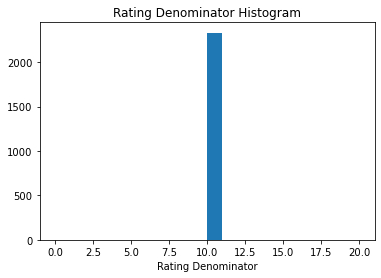

In [18]:
plt.hist(archive.query('rating_denominator >= 0 & rating_denominator <= 20')['rating_denominator'], bins=20)
plt.title('Rating Denominator Histogram')
plt.xlabel('Rating Denominator');

It appears that the mode for `rating_denominator` is 10, so I will filter for all `text` associated with `rating_denominator` that are not 10.

In [19]:
archive.query('rating_denominator != 10')['text']

313                                                                            @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
342                                                                                                                                      @docmisterio account started on 11/15/15
433                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784                                  RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902                                                                                                Why does th

Some of these ratings are wrong, and the reason is because there are other fractions within the `text` or no actual ratings at all.

Now I will go through the same process with `rating_numerator`.

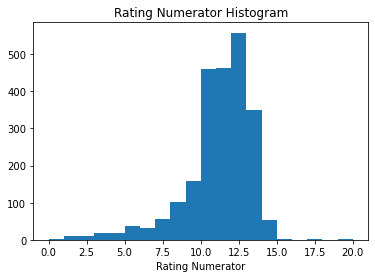

In [20]:
plt.hist(archive.query('rating_numerator >= 0 & rating_numerator <= 20')['rating_numerator'], bins=20)
plt.title('Rating Numerator Histogram')
plt.xlabel('Rating Numerator');

It looks like there are very few `rating_numerator` below 5 and greater than or equal to 15, so I will look at the `text` related to these.

In [21]:
archive.query('rating_numerator >= 15')['text']

55                                                                                    @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
188                                                                                        @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
189                                         @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
285                                                                               RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
290                                                                                                                                                            @markhoppus 182/10
291                                                                                                           

Like before, some of these are incorrect because the wrong fraction was extracted. However, I also see that some of the `rating_numerator` should include decimals. The provided data did not take this into account. Given that decimals should be included, the `rating_numerator` and `rating_denominator` should also be converted to data type `float`.

In [22]:
 with pd.option_context('display.max_rows', None):   
    print(archive.query('rating_numerator < 5')['text'])

315                                When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
605     RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…
765     This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M
883     This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP
912     Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl
1004      Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
1016                         PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 m

Most of these are valid ratings. Only a few have issues, which are the same as the ones mentioned previously.

Now I will look common values in the `name` column to identify any issues.

In [23]:
archive['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
            ... 
Grizzwald      1
Kial           1
Katie          1
Carbon         1
Eriq           1
Name: name, Length: 957, dtype: int64

It is unlikely that "None" is the name for so many dogs, so these will have to be replaced with NaN.

I also want to look up any values in the `name` column that do not start with a capital letter. This is a clear indication that it is not actually a name.

In [24]:
# use regex to find all lowercase names
archive[archive['name'].str.contains(r'^[^A-Z].*$')]['name'].value_counts()

a               55
the              8
an               7
very             5
one              4
just             4
quite            4
actually         2
mad              2
not              2
getting          2
this             1
officially       1
all              1
infuriating      1
light            1
my               1
incredibly       1
his              1
life             1
space            1
by               1
such             1
unacceptable     1
old              1
Name: name, dtype: int64

I will look at the `text` associated with these non-names to see if there are any commonalities between them.

In [25]:
with pd.option_context('display.max_rows', None):
    print(archive[archive['name'].str.contains(r'^[^A-Z].*$')]['text'])

22                                    I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
56             Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
118                           RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…
169                   We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9
193     Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
335                                                               There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  

I see two trends here. First, a lot of these tweets, according to WeRateDogs, are not pictures of dogs. In this case, the account posts "We only rate dogs" and does not include a name. The second trend is that a lot of names are included after the word "named".

Now I will take a look at unique values in each of the stage columns to see how the stages are denoted. In addition, I will extract the stages myself to see if it matches what is in the dataframe. When I extract the stages, I will allow the letters to be uppercase or lowercase, repeated letters (as long as the necessary letters are in the correct order), and an optional "s" at the end.

In [26]:
def stage_comparison(stage, regex):
    '''Prints value counts of original stage name extractions, then re-extracts using the provided regex and outputs a comparison summary.'''
    print('Original value counts for {}:\n'.format(stage))
    print(archive[stage].value_counts())
    print('\n')
    print('New value counts:\n')
    print(archive['text'].str.extract(regex)[0].value_counts())
    print('\n')
    print('New total: {}'.format(archive['text'].str.extract(regex)[0].count()))

In [27]:
stage_comparison('doggo', '([Dd]+[Oo]+[Gg]+[Oo]+[Ss]*)')

Original value counts for doggo:

None     2259
doggo      97
Name: doggo, dtype: int64


New value counts:

doggo     87
doggos    10
Doggo      9
DOGGO      1
Name: 0, dtype: int64


New total: 107


In [28]:
stage_comparison('floofer', '([Ff]+[Ll]+[Oo]+[Ff]+[Ee]+[Rr]+[Ss]*)')

Original value counts for floofer:

None       2346
floofer      10
Name: floofer, dtype: int64


New value counts:

Floofer    6
floofer    4
Name: 0, dtype: int64


New total: 10


In [29]:
stage_comparison('pupper', '([Pp]+[Uu]+[Pp]+[Ee]+[Rr]+[Ss]*)')

Original value counts for pupper:

None      2099
pupper     257
Name: pupper, dtype: int64


New value counts:

pupper     247
puppers     23
Pupper       8
PUPPER       5
Name: 0, dtype: int64


New total: 283


In [30]:
stage_comparison('puppo', '([Pp]+[Uu]+[Pp]+[Oo]+[Ss]*)')

Original value counts for puppo:

None     2326
puppo      30
Name: puppo, dtype: int64


New value counts:

puppo     35
puppos     2
Puppo      1
Name: 0, dtype: int64


New total: 38


For all of the stages, it looks like there are variations on the stage names that were not extracted.

Now I will assess the `predictions` dataframe. First, I will look at any duplicated rows, `tweet_id`, or `jpg_url`, which are the images being used for the predictions.

In [31]:
sum(predictions.duplicated())

0

In [32]:
sum(predictions.duplicated('tweet_id'))

0

In [33]:
sum(predictions.duplicated('jpg_url'))

66

I will look up the `tweet_id` related to the duplicated `jpg_url` in the `archive` dataframe to see if there are any commonalities.

In [34]:
duplicated_jpg_url = predictions[predictions.duplicated('jpg_url')]['tweet_id']

In [35]:
archive.query('tweet_id in @duplicated_jpg_url')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,"https://twitter.com/dog_rates/status/868880397819494401/photo/1,https://twitter.com/dog_rates/status/868880397819494401/photo/1",14,10,Walter,None,None,None,None
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Good afternoon class today we're going to learn what makes a good boy so good"" 13/10 https://t.co/f1h2Fsalv9",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,"https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1",13,10,None,None,None,None,None
211,851953902622658560,NaN,NaN,2017-04-12 00:23:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao,8.293743e+17,4.196984e+09,2017-02-08 17:00:26 +0000,"https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1",13,10,Astrid,doggo,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,759566828574212096,NaN,NaN,2016-07-31 01:50:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000,"https://twitter.com/dog_rates/status/739544079319588864/photo/1,https://twitter.com/dog_rates/status/739544079319588864/photo/1",10,10,None,None,None,None,None
895,759159934323924993,NaN,NaN,2016-07-29 22:53:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO7HEQGA,6.703191e+17,4.196984e+0

It looks like a lot of these duplicated `jpg_url` are related to retweets. I can confirm below.

In [36]:
# confirm the number of retweets within duplicated jpg_url
archive.query('tweet_id in @duplicated_jpg_url')['retweeted_status_id'].count()

66

Therefore, the duplicated `jpg_url` should not be in the `predictions` dataframe.

Now I will use the `info()` function.

In [37]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


All of these data types look fine, and there are no missing values.

Next I will look at the descriptive statistics for `predictions`.

In [38]:
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


One thing that looks odd is the fact that the maximum value for `p1_conf` is 1. That would make it impossible for there to be `p2` and `p3`, but the previous `info()` showed that there were no missing values. Therefore, I will search for rows where the total confidence is greater than 1.

In [39]:
predictions.query('p1_conf+p2_conf+p3_conf > 1')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
106,667866724293877760,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,jigsaw_puzzle,1.0,False,prayer_rug,1.011300e-08,False,doormat,1.740170e-10,False


This row also brings up the idea that there should not be any rows in which all three predictions are not dogs, as that data is unhelpful to my analysis. I will search the `predictions` dataframe further to see if there are any other rows that should be eliminated because all three predictions are not dogs.

In [40]:
predictions.query('p1_dog == False & p2_dog == False & p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


I also want to check each of the prediction columns (`p1`, `p2`, and `p3`) to see if there are any inconsistencies in formatting separate words. My visual assessment showed that an underscore is used in place of a space, and I want to confirm if that is the case for the entire dataframe.

In [41]:
predictions[predictions['p1'].str.contains(' ')]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [42]:
predictions[predictions['p2'].str.contains(' ')]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [43]:
predictions[predictions['p3'].str.contains(' ')]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


All of the prediction columns are consistent in formatting separate words.

Finally, I will look at the `tweet_data` dataframe. Again, I will check for any duplicated rows and `tweet_id`, and also use the `info()` function.

In [44]:
sum(tweet_data.duplicated())

0

In [45]:
sum(tweet_data.duplicated('tweet_id'))

0

In [46]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


There are no missing values and all data types are correct.

Next I will look at descriptive statistics.

In [47]:
tweet_data.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2653.586873,7457.370227
std,6.823170e+16,4488.034968,11576.936469
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,537.000000,1297.000000
50%,7.182469e+17,1242.000000,3244.000000
75%,7.986692e+17,3081.500000,9133.500000
max,8.924206e+17,76272.000000,153873.000000


The descriptive statistics look reasonable, however I also want to check the correlation between `retweet_count` and `favorite_count`. I would expect that as there is more interaction from Twitter users, both `retweet_count` and `favorite_count` increase, so there would be a positive correlation. In order to visualize the correlation, I will use a scatter plot.

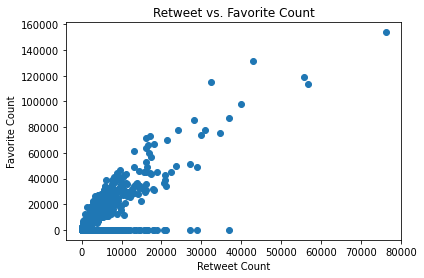

In [48]:
plt.scatter(x=tweet_data['retweet_count'], y=tweet_data['favorite_count'])
plt.title('Retweet vs. Favorite Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

The scatter shows one odd trend -- there is a series of tweets where the `retweet_count` is high, yet the `favorite_count` stays very low regardless. I will look into these by filtering for tweets in which the `retweet_count` is greater than the `favorite_count`.

In [49]:
tweet_data.query('retweet_count > favorite_count')

,tweet_id,retweet_count,favorite_count
31,886054160059072513,99,0
35,885311592912609280,16561,0
67,879130579576475649,6110,0
72,878404777348136964,1148,0
73,878316110768087041,5959,0
...,...,...,...
999,746521445350707200,967,0
1019,743835915802583040,2029,0
1218,711998809858043904,125,0
2234,667550904950915073,31,0


It looks like a lot of these have 0 as the `favorite_count`. I will confirm this by seeing if there are any rows in this subset that do not have 0 as the `favorite_count`.

In [50]:
tweet_data.query('retweet_count > favorite_count & favorite_count != 0')

,tweet_id,retweet_count,favorite_count


I will use the `tweet_id` associated with the 0 `favorite_count` and look them up in the `archive` dataframe.

In [51]:
zero_favorite_count = tweet_data.query('favorite_count == 0')['tweet_id']

In [52]:
archive.query('tweet_id in @zero_favorite_count')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https:/…,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724293877760/photo/1,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0Dv…,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269671505920/photo/1,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @twitter: @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter https://t.co/j6FQGhxYuN,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,"https://twitter.com/twitter/status/711998279773347841/photo/1,https://twitter.com/twitter/status/711998279

It looks like a lot of these are related to retweets, which makes sense. The `favorite_count` would not go to WeRateDogs, but rather to the original poster. I will confirm that all of these are related to retweets below. Because I only want original content in my analysis, the rows with 0 as the `favorite_count` should not be in the dataframe.

In [53]:
archive.query('tweet_id in @zero_favorite_count')['retweeted_status_id'].count()

163

To conclude the Assess section, here is a summary of assessments that I have made.

Tidiness issues:

`archive`

- The stage columns (`doggo`, `floofer`, `pupper`, and `puppo`) are not tidy

`predictions`

- The columns related to prediction 1, prediction 2, and prediction 3 are not tidy

Other

- The data is not tidy because each dataframe is not its own observational unit; there should be one each for tweet data, dog data, and image predictions

Quality issues:

`archive`

- When the data tidiness is corrected, the stage columns (`doggo`, `floofer`, `pupper`, and `puppo`) should have the categorical data type
- `timestamp` should have the `datetime` data type
- The dataframe is not solely original content with images (there are retweets and posts without linked content)
- Some ratings are incorrectly extracted and should include decimals using data type `float`
- Many dogs names are "None" or lowercase words, which are incorrect
- Variations of the stage names have not been extracted correctly

`predictions`

- When the data tidiness is corrected, the prediction number needs to have data type `int`
- The values in `p1`, `p2`, and `p3` are inconsistent in the first letter capitalization
- Not all of the images have a dog-related prediction
- There are duplicated `jpg_url`, which are related to retweets
- One row has total confidence of greater than 1

`tweet_data`

- Some tweets in `archive` have missing data for `retweet_count` or `favorite_count` (cannot be retrieved elsewhere)
- Many rows have 0 as the `favorite_count`; these are related to retweets

<a id='clean'></a>
## Clean

To begin the cleaning process, I will first make copies of each dataframe. Then, for each step of cleaning, I will define the process, write the code, and then test to see if the changes were made.

In [54]:
archive_clean = archive.copy()
predictions_clean = predictions.copy()
tweet_data_clean = tweet_data.copy()

In the first section of cleaning, I will narrow down `archive_clean` and `predictions_clean` to only original content with images of dogs.

#### Define

Remove retweets by dropping rows in `archive_clean` that have values in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`, and then drop those three columns.

#### Code

In [55]:
# remove retweets
archive_clean = archive_clean[archive_clean['retweeted_status_id'].isnull()]

In [56]:
# drop columns related to retweets that should be null now
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [57]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

#### Define

Query for rows in `predictions_clean` with `tweet_id` that are also in `archive_clean` to remove retweets. This should also remove the duplicated values in the `jpg_url` column.

#### Code

In [58]:
archive_clean_tweets = archive_clean['tweet_id']

In [59]:
predictions_clean = predictions_clean.query('tweet_id in @archive_clean_tweets')

#### Test

In [60]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1994 non-null   int64  
 1   jpg_url   1994 non-null   object 
 2   img_num   1994 non-null   int64  
 3   p1        1994 non-null   object 
 4   p1_conf   1994 non-null   float64
 5   p1_dog    1994 non-null   bool   
 6   p2        1994 non-null   object 
 7   p2_conf   1994 non-null   float64
 8   p2_dog    1994 non-null   bool   
 9   p3        1994 non-null   object 
 10  p3_conf   1994 non-null   float64
 11  p3_dog    1994 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 161.6+ KB


In [61]:
sum(predictions_clean['jpg_url'].duplicated())

0

#### Define

Remove records in `predictions_clean` that are probably not pictures of dogs by querying for rows that have at least one `True` value between `p1_dog`, `p2_dog`, and `p3_dog`. This should also drop the row with confidence greater than 1.

#### Code

In [62]:
predictions_clean = predictions_clean.query('p1_dog == True | p2_dog == True | p3_dog == True')

#### Test

In [63]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1686 non-null   int64  
 1   jpg_url   1686 non-null   object 
 2   img_num   1686 non-null   int64  
 3   p1        1686 non-null   object 
 4   p1_conf   1686 non-null   float64
 5   p1_dog    1686 non-null   bool   
 6   p2        1686 non-null   object 
 7   p2_conf   1686 non-null   float64
 8   p2_dog    1686 non-null   bool   
 9   p3        1686 non-null   object 
 10  p3_conf   1686 non-null   float64
 11  p3_dog    1686 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 136.7+ KB


In [64]:
predictions_clean.query('p1_conf+p2_conf+p3_conf > 1')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Define

Only keep rows in `archive_clean` that have `tweet_id` also in `predictions_clean` to remove records that are not images of dogs.

#### Code

In [65]:
predictions_clean_tweets = predictions_clean['tweet_id']

In [66]:
archive_clean = archive_clean.query('tweet_id in @predictions_clean_tweets')

#### Test

In [67]:
# check that archive_clean and predictions_clean now have the same number of tweets
assert len(archive_clean)==len(predictions_clean)

In the next section, I make sure that the data is tidy by splitting it into three dataframes.

#### Define

Left join `tweet_data_clean` to `archive_clean` on `tweet_id` to put all tweet data in the same dataframe. Because `archive_clean` does not have any retweets, this should also remove any `favorite_count` with value 0.

#### Code

In [68]:
archive_clean = archive_clean.merge(tweet_data_clean, how='left', on='tweet_id')

#### Test

In [69]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 1685
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1686 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1686 non-null   object 
 4   source                 1686 non-null   object 
 5   text                   1686 non-null   object 
 6   expanded_urls          1686 non-null   object 
 7   rating_numerator       1686 non-null   int64  
 8   rating_denominator     1686 non-null   int64  
 9   name                   1686 non-null   object 
 10  doggo                  1686 non-null   object 
 11  floofer                1686 non-null   object 
 12  pupper                 1686 non-null   object 
 13  puppo                  1686 non-null   object 
 14  retweet_count          1679 non-null   float64
 15  favo

In [70]:
assert len(archive_clean)==len(predictions_clean)

In [71]:
archive_clean.query('favorite_count == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count


#### Define

Use `melt()` function to make `predictions_clean` tidy. Because the prediction, confidence, and dog status are all separate variables, I will perform this three times to produce three different dataframes, and then merge them all together on the common columns. Before melting, I will also change the column names to 1, 2, and 3, since those are the valid values for the prediction number.

#### Code

In [72]:
def melt_predictions(p1, p2, p3, value_name):
    '''Melts dataframe for prediction columns.'''
    df = predictions_clean[['tweet_id', 'jpg_url', 'img_num', p1, p2, p3]]
    # change column names so that they do not have to be extracted later
    df.rename(columns={p1: 1, p2: 2, p3: 3}, inplace=True)
    df = pd.melt(df, id_vars=['tweet_id', 'jpg_url', 'img_num'], value_vars=[1, 2, 3], var_name='prediction_num', value_name=value_name)
    return df

In [73]:
predictions_names = melt_predictions('p1', 'p2', 'p3', 'prediction')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:
predictions_conf = melt_predictions('p1_conf', 'p2_conf', 'p3_conf', 'confidence')

In [75]:
predictions_dog = melt_predictions('p1_dog', 'p2_dog', 'p3_dog', 'dog_status')

In [76]:
# merge together the three melted dataframes
predictions_clean = predictions_names.merge(predictions_conf, how='inner', on=['tweet_id', 'jpg_url', 'img_num', 'prediction_num'])

In [77]:
predictions_clean = predictions_clean.merge(predictions_dog, how='inner', on=['tweet_id', 'jpg_url', 'img_num', 'prediction_num'])

#### Test

In [78]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5058 entries, 0 to 5057
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        5058 non-null   int64  
 1   jpg_url         5058 non-null   object 
 2   img_num         5058 non-null   int64  
 3   prediction_num  5058 non-null   object 
 4   prediction      5058 non-null   object 
 5   confidence      5058 non-null   float64
 6   dog_status      5058 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 281.5+ KB


In [79]:
# check that the number of unique tweets in predictions_clean is still the same as archive_clean
predictions_clean['tweet_id'].nunique()

1686

I will also have to change the `prediction_num` column to data type `int`.

Before I make the dog data tidy by separating it from the tweet data, I will first make necessary corrections to `name`, `rating_numerator`, `rating_denominator`, and the stage columns, since it will be easiest to clean those while they are still in the same dataframe as the `text` column.

#### Define

Remove any invalid values in the `name` column in `archive_clean` by first extracting any name that comes after "named". Next I will examine any remaining `text` related to lowercase names that do not have the phrase "We only rate dogs". Then I will create a dictionary for any corrections that need to be made and change the appropriate values. Finally, I will change any remaining lowercase names or "None" to NaN.

#### Code

In [80]:
# allow for dogs with multiple names in regex
archive_clean['named'] = archive_clean['text'].str.extract('named ([A-Z][a-z]*(\s[A-Z][a-z]*)*)')[0]

In [81]:
# replace cells with names that come after 'named'
archive_clean.loc[archive_clean['named'].notnull(), 'name'] = archive_clean[archive_clean['named'].notnull()]['named']

In [82]:
archive_clean.drop('named', axis=1, inplace=True)

In [83]:
# print text related to lowercase names that do not have the phrase 'We only rate dogs'
with pd.option_context('display.max_rows', None):
    print(archive_clean[archive_clean['name'].str.contains(r'^[^A-Z].*$') & ~archive_clean['text'].str.contains(r'[Ww]e only rate dogs')][['text']])

                                                                                                                                                             text
46    Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
247                                                      Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK
560                        This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB
657                      What jokester sent in a pic without a dog in it? This is not @rock_rates. This is @dog_rates. Thank you ...10/10 https://t.co/nDPaYHrtNX
660                  This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd
666                  This is

In [84]:
# use a dictionary to capture any one-off name patterns
name_dict = {247: 'Grace', 560: 'Zoey', 1629: 'Daryl'}

In [85]:
for index, name in name_dict.items():
    archive_clean.iloc[index, 9] = name

In [86]:
# replace all remaining lowercase names with NaN
archive_clean.loc[archive_clean['name'].str.contains(r'^[^A-Z].*$'), 'name'] = np.nan

In [87]:
# replace all 'None' names with NaN
archive_clean.loc[archive_clean['name']=='None', 'name'] = np.nan

#### Test

In [88]:
archive_clean['name'].value_counts()

Cooper     10
Charlie    10
Lucy       10
Tucker      9
Oliver      9
           ..
BeBe        1
Julio       1
Duchess     1
Ester       1
Eriq        1
Name: name, Length: 852, dtype: int64

In [89]:
# check for remaining lowercase names
archive_clean['name'].str.extract('(^[^A-Z].*$)')[0].unique()

array([nan], dtype=object)

#### Define

Extract the `rating_numerator` and `rating_denominator` from the `text` column and include possible decimals.

#### Code

In [90]:
# allow for digits with decimals in regex
archive_clean[['rating_numerator', 'rating_denominator']] = archive_clean['text'].str.extract('(\d+\.?\d*)/(\d+\.?\d*)').astype(float)

#### Test

In [91]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 1685
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1686 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1686 non-null   object 
 4   source                 1686 non-null   object 
 5   text                   1686 non-null   object 
 6   expanded_urls          1686 non-null   object 
 7   rating_numerator       1686 non-null   float64
 8   rating_denominator     1686 non-null   float64
 9   name                   1210 non-null   object 
 10  doggo                  1686 non-null   object 
 11  floofer                1686 non-null   object 
 12  pupper                 1686 non-null   object 
 13  puppo                  1686 non-null   object 
 14  retweet_count          1679 non-null   float64
 15  favo

In [92]:
archive_clean.query('rating_denominator != 10.')['text']

292                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
348     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
593                                                                                                Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
710                                  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
791                                                                                                              Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
821                                                         This is Bluebert. He just saw that both #FinalFur 

Most of these are valid ratings, but there are a few that still need corrections.

#### Define

Create a dictionary with corrected ratings and change the appropriate values. Also, I will drop the row at index 348 since that is not actually a rating.

#### Code

In [93]:
# use dictionaries to capture any one-off numerator and denominator patterns
numerator_dict = {710: 14., 791: 13., 821: 11., 1169: 10., 1668: 9.}
denominator_dict = {710: 10., 791: 10., 821: 10., 1169: 10., 1668: 10.}

In [94]:
for index, numerator in numerator_dict.items():
    archive_clean.iloc[index, 7] = numerator

In [95]:
for index, denominator in denominator_dict.items():
    archive_clean.iloc[index, 8] = denominator

In [96]:
# drop row that is not actually a rating
archive_clean.drop(348, inplace=True)

#### Test

In [97]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1685
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1685 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1685 non-null   object 
 4   source                 1685 non-null   object 
 5   text                   1685 non-null   object 
 6   expanded_urls          1685 non-null   object 
 7   rating_numerator       1685 non-null   float64
 8   rating_denominator     1685 non-null   float64
 9   name                   1209 non-null   object 
 10  doggo                  1685 non-null   object 
 11  floofer                1685 non-null   object 
 12  pupper                 1685 non-null   object 
 13  puppo                  1685 non-null   object 
 14  retweet_count          1678 non-null   float64
 15  favo

In [98]:
archive_clean.query('rating_denominator != 10.')['text']

292                                                    The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
593                                                                         Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
840                                                          Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
859                                           Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
876     From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
936                                                                     Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
1002                                                          Happy We

In [99]:
archive_clean.query('rating_numerator >= 15.')['text']

292                                                    The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
593                                                                         Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
840                                                          Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
859                                           Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
876     From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
936                                                                     Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
1002                                                          Happy We

#### Define

Extract the dog stages, allowing for uppercase or lowercase, repeated letters, and optional "s" at the end.

#### Code

In [100]:
archive_clean['doggo'] = archive_clean['text'].str.extract('([Dd]+[Oo]+[Gg]+[Oo]+[Ss]*)')
archive_clean['floofer'] = archive_clean['text'].str.extract('([Ff]+[Ll]+[Oo]+[Ff]+[Ee]+[Rr]+[Ss]*)')
archive_clean['pupper'] = archive_clean['text'].str.extract('([Pp]+[Uu]+[Pp]+[Ee]+[Rr]+[Ss]*)')
archive_clean['puppo'] = archive_clean['text'].str.extract('([Pp]+[Uu]+[Pp]+[Oo]+[Ss]*)')

#### Test

In [101]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1685
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1685 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1685 non-null   object 
 4   source                 1685 non-null   object 
 5   text                   1685 non-null   object 
 6   expanded_urls          1685 non-null   object 
 7   rating_numerator       1685 non-null   float64
 8   rating_denominator     1685 non-null   float64
 9   name                   1209 non-null   object 
 10  doggo                  68 non-null     object 
 11  floofer                8 non-null      object 
 12  pupper                 195 non-null    object 
 13  puppo                  28 non-null     object 
 14  retweet_count          1678 non-null   float64
 15  favo

In [102]:
archive_clean['doggo'].value_counts()

doggo     61
doggos     4
Doggo      3
Name: doggo, dtype: int64

In [103]:
archive_clean['floofer'].value_counts()

Floofer    5
floofer    3
Name: floofer, dtype: int64

In [104]:
archive_clean['pupper'].value_counts()

pupper     170
puppers     16
Pupper       6
PUPPER       3
Name: pupper, dtype: int64

In [105]:
archive_clean['puppo'].value_counts()

puppo     26
puppos     1
Puppo      1
Name: puppo, dtype: int64

Now I can separate the dog data into its own dataframe.

#### Define

Create the `dogs_clean` dataframe by taking columns `tweet_id`, `rating_numerator`, `rating_denominator`, `name`, `doggo`, `floofer`, `pupper`, and `puppo` from `archive_clean`, and then drop those columns in `archive_clean`.

#### Code

In [106]:
dogs_clean = archive_clean[['tweet_id', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']]

In [107]:
archive_clean.drop(['rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [108]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1685
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1685 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1685 non-null   object 
 4   source                 1685 non-null   object 
 5   text                   1685 non-null   object 
 6   expanded_urls          1685 non-null   object 
 7   retweet_count          1678 non-null   float64
 8   favorite_count         1678 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 131.6+ KB


In [109]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1685
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1685 non-null   int64  
 1   rating_numerator    1685 non-null   float64
 2   rating_denominator  1685 non-null   float64
 3   name                1209 non-null   object 
 4   doggo               68 non-null     object 
 5   floofer             8 non-null      object 
 6   pupper              195 non-null    object 
 7   puppo               28 non-null     object 
dtypes: float64(2), int64(1), object(5)
memory usage: 118.5+ KB


#### Define

Use `melt()` function on the columns `doggo`, `floofer`, `pupper`, and `puppo`. Then I will remove any missing values and use this new dataframe to check for duplicated `tweet_id`, or any dogs that have multiple stages. I will look up these duplicated `tweet_id` in `archive_clean` and create another dataframe to keep track of them. Next, I will review the related `text` to see what the actual stages should be and add them to the dataframe of duplicated `tweet_id`, as well as a column to note which records should be kept. I will then merge this back on the original melted dataframe, remove any duplicated `tweet_id` that are not noted as "keep", and that will give me a definitive dataframe of stages. Finally, I will left join this back on `dogs_clean` and drop the stage columns to make the dataframe tidy.

#### Code

In [110]:
dogs_stage = pd.melt(dogs_clean, id_vars='tweet_id', value_vars=['doggo', 'floofer', 'pupper', 'puppo'], var_name='stage', value_name='stage_text')

In [111]:
# drop all tweets that do not have a valid stage name
dogs_stage_notnull = dogs_stage.dropna(subset=['stage_text'])

In [112]:
# find dogs with more than one stage
sum(dogs_stage_notnull.duplicated('tweet_id'))

11

In [113]:
dogs_stage_tweets = dogs_stage_notnull[dogs_stage_notnull.duplicated('tweet_id')]['tweet_id']

In [114]:
# use archive_clean to determine actual stage of duplicated 'tweet_id' and create a dataframe to keep track
archive_stage_tweets = archive_clean.query('tweet_id in @dogs_stage_tweets')[['tweet_id', 'text']]
archive_stage_tweets

,tweet_id,text
123,858843525470990336,I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq
134,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
140,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"
306,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7"
360,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
378,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze"
383,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
583,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll"
629,751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8
706,741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC


In [115]:
archive_stage_tweets['stage'] = ['doggo', 'puppo', 'floofer', 'pupper', np.nan, np.nan, 'pupper', np.nan, np.nan, np.nan, np.nan]

In [116]:
# create a column to indicate that the above values should be kept
archive_stage_tweets['keep'] = 'keep'

In [117]:
archive_stage_tweets.drop('text', axis=1, inplace=True)

In [118]:
# merge the dataframe with the 'keep' flag back on the dataframe of dogs with valid stage names
dogs_stage_notnull = dogs_stage_notnull.merge(archive_stage_tweets, how='left', on=['tweet_id', 'stage'])

In [119]:
# drop rows that are in the duplicated 'tweet_id' and are not flagged as 'keep'
dogs_stage_notnull.drop(dogs_stage_notnull[dogs_stage_notnull['tweet_id'].isin(dogs_stage_tweets) & dogs_stage_notnull['keep'].isnull()].index, inplace=True)

In [120]:
sum(dogs_stage_notnull.duplicated('tweet_id'))

0

In [121]:
dogs_stage_notnull.drop(['stage_text', 'keep'], axis=1, inplace=True)

In [122]:
# left join dataframe of dogs with valid stage names back on the original dogs_clean dataframe
dogs_clean = dogs_clean.merge(dogs_stage_notnull, how='left', on='tweet_id')

In [123]:
dogs_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [124]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1684
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1685 non-null   int64  
 1   rating_numerator    1685 non-null   float64
 2   rating_denominator  1685 non-null   float64
 3   name                1209 non-null   object 
 4   stage               282 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 79.0+ KB


Now the dataframes are tidy.

#### Define

Change all characters in the `prediction` column to lowercase for consistency.

#### Code

In [125]:
predictions_clean['prediction'] = predictions_clean['prediction'].str.lower()

#### Test

In [126]:
predictions_clean.head()

,tweet_id,jpg_url,img_num,prediction_num,prediction,confidence,dog_status
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,1,german_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,1,rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,1,miniature_pinscher,0.560311,True


#### Define

Change column `timestamp` in `archive_clean` to the `datetime` data type, column `stage` in `dogs_clean` to the `category` data type, and column `prediction_num` in `predictions_clean` to the `int` data type.

#### Code

In [127]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

In [128]:
dogs_clean['stage'] = dogs_clean['stage'].astype('category')

In [129]:
predictions_clean['prediction_num'] = predictions_clean['prediction_num'].astype(int)

#### Test

In [130]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1685
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1685 non-null   int64              
 1   in_reply_to_status_id  20 non-null     float64            
 2   in_reply_to_user_id    20 non-null     float64            
 3   timestamp              1685 non-null   datetime64[ns, UTC]
 4   source                 1685 non-null   object             
 5   text                   1685 non-null   object             
 6   expanded_urls          1685 non-null   object             
 7   retweet_count          1678 non-null   float64            
 8   favorite_count         1678 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(3)
memory usage: 131.6+ KB


In [131]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1684
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1685 non-null   int64   
 1   rating_numerator    1685 non-null   float64 
 2   rating_denominator  1685 non-null   float64 
 3   name                1209 non-null   object  
 4   stage               282 non-null    category
dtypes: category(1), float64(2), int64(1), object(1)
memory usage: 67.7+ KB


In [132]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5058 entries, 0 to 5057
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        5058 non-null   int64  
 1   jpg_url         5058 non-null   object 
 2   img_num         5058 non-null   int64  
 3   prediction_num  5058 non-null   int64  
 4   prediction      5058 non-null   object 
 5   confidence      5058 non-null   float64
 6   dog_status      5058 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 281.5+ KB


<a id='store'></a>
## Store

Now that the dataframes are cleaned, I will store them in three separate CSV files.

In [133]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)

In [134]:
dogs_clean.to_csv('dog_data_master.csv', index=False)

In [135]:
predictions_clean.to_csv('image_predictions_master.csv', index=False)

<a id='analysis'></a>
## Exploratory Data Analysis

### Question 1: What is WeRateDogs's posting trend by month?

To answer this question, I will need to find the year and month of each `timestamp`, and then group the count of `tweet_id` by the year and month.

In [136]:
monthly_tweets_count = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_id'].count()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


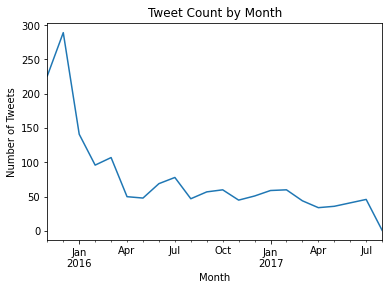

In [137]:
monthly_tweets_count.plot()
plt.title('Tweet Count by Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets');

The number of ratings that WeRateDogs has posted each month has decreased since the account was first started.

### Question 2: What is the monthly trend of interactions with WeRateDogs's posts?

Here I will define "interactions" as the sum of retweets and favorites. I will create a new column called `tweet_activity` with this sum, and then use a similar process as before to find the average `tweet_activity` per tweet by month.

In [138]:
archive_clean['tweet_activity'] = archive_clean['retweet_count']+archive_clean['favorite_count']

In [139]:
monthly_tweet_activity = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_activity'].mean()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


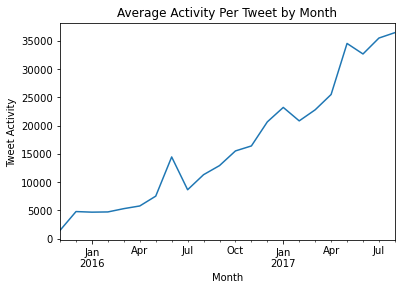

In [140]:
monthly_tweet_activity.plot()
plt.title('Average Activity Per Tweet by Month')
plt.xlabel('Month')
plt.ylabel('Tweet Activity');

The interaction with WeRateDogs's ratings has increased since the account was first started.

### Question 3: What are the most popular dog breeds based on number of posts, interactions by Twitter users, and ratings?

In order to identify the dog breed on each post, I will use the highest confidence prediction that is a dog. I will find the maximum for `predictions_clean` grouped by `tweet_id`, and then use an inner join to filter `predictions_clean` for only these maximum values.

In [141]:
best_dog_predictions = predictions_clean.query('dog_status == True').groupby('tweet_id', as_index=False)['confidence'].max()

In [142]:
# use dataframe of maximum-confidence dog predictions to filter predictions_clean
best_dog_predictions = predictions_clean.merge(best_dog_predictions, how='inner', on=['tweet_id', 'confidence'])

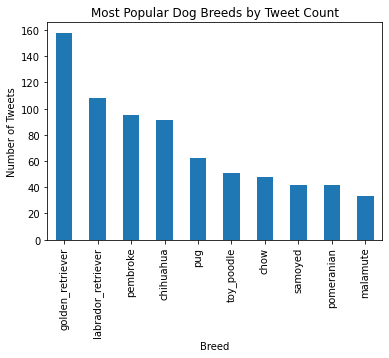

In [143]:
best_dog_predictions['prediction'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Most Popular Dog Breeds by Tweet Count')
plt.xlabel('Breed')
plt.ylabel('Number of Tweets');

Golden retrievers are, by far, the most commonly rated breed by WeRateDogs. Labrador retrievers, pembrokes, and chihuahua also have a larger amount of posts compared to the rest of the top 10.

Next I will find the top 10 breeds by the average `tweet_activity` per post. However, a given breed may only have one rating and lots of interaction on that post. However, this is probably not enough evidence that the breed is actually popular. Therefore, I will limit my analysis only to breeds which have had at least 10 ratings.

In [144]:
# filter for breeds that have had at least 10 ratings
eligible_dogs = best_dog_predictions['prediction'].value_counts()[best_dog_predictions['prediction'].value_counts() >= 10].index

Now I will merge `archive_clean` and `best_dog_predictions` so that the data on interactions and breeds are in the same dataframe. Then I can group the average `tweet_activity` by `prediction` and filter only for eligible breeds.

In [145]:
def by_breed(df, col):
    '''Returns averages for the specified column by dog breed for eligible breeds.'''
    new_df = df.merge(best_dog_predictions, how='inner', on='tweet_id')
    by_breed = new_df.groupby('prediction')[col].mean()
    by_breed = by_breed[by_breed.index.isin(eligible_dogs)]
    return by_breed

In [146]:
activity_by_breed = by_breed(archive_clean, 'tweet_activity')

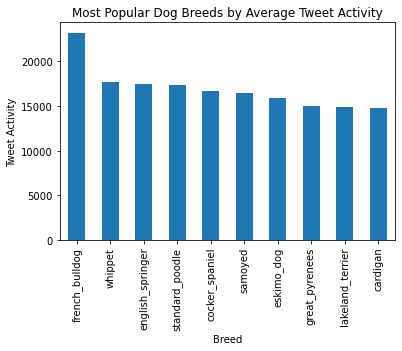

In [147]:
activity_by_breed.nlargest(10).plot(kind='bar')
plt.title('Most Popular Dog Breeds by Average Tweet Activity')
plt.xlabel('Breed')
plt.ylabel('Tweet Activity');

Out of all breeds that have had at least 10 ratings, the French bulldog has a large margin over the rest of the top 10 in terms of Twitter user interaction.

Now I also want to see if analyzing the average ratings by breed is feasible by checking for any outliers in a histogram.

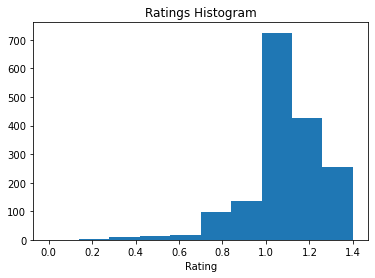

In [148]:
plt.hist(dogs_clean['rating_numerator']/dogs_clean['rating_denominator'])
plt.title('Ratings Histogram')
plt.xlabel('Rating');

There are no outliers here so I will analyze the average ratings by breed. I will go through the same process as before.

In [149]:
dogs_clean['rating'] = dogs_clean['rating_numerator']/dogs_clean['rating_denominator']

In [150]:
ratings_by_breed = by_breed(dogs_clean, 'rating')

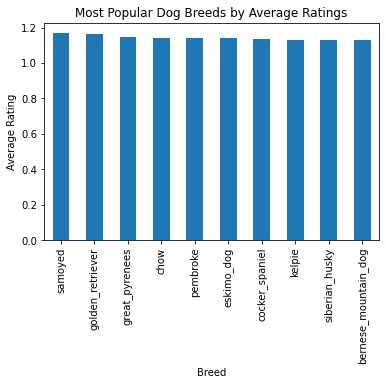

In [151]:
ratings_by_breed.nlargest(10).plot(kind='bar')
plt.title('Most Popular Dog Breeds by Average Ratings')
plt.xlabel('Breed')
plt.ylabel('Average Rating');

There does not appear to be much difference between the top 10 dog breeds by average ratings. This is to be expected given that the ratings are pretty arbitrary. This brings me to the final question.

### Question 4: Is there any correlation between WeRateDogs's ratings and the interactions by Twitter users?

I will plot the average ratings against the average Twitter activity only for eligible breeds to see if there is any correlation.

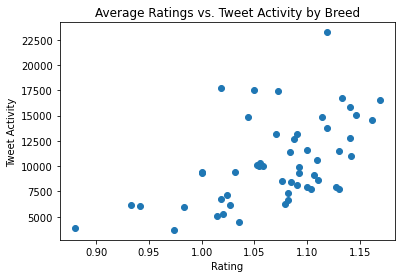

In [152]:
plt.scatter(ratings_by_breed, activity_by_breed)
plt.title('Average Ratings vs. Tweet Activity by Breed')
plt.xlabel('Rating')
plt.ylabel('Tweet Activity');

Surprisingly, there appears to be a positive correlation between average ratings and average activity. I am curious about how strong this correlation is, so I will use the Pearson correlation coefficient.

In [153]:
pearsonr(ratings_by_breed, activity_by_breed)

(0.5357749759080439, 3.560612505691052e-05)

This shows that there is a moderate positive correlation between average ratings and average activity by breed.

I also want to see if there is any correlation between rating and activity by each individual post. To find this, I will first need to merge `archive_clean` and `dogs_clean` to put the ratings and activity in the same dataframe.

In [154]:
archive_dogs = archive_clean.merge(dogs_clean, how='inner', on='tweet_id')

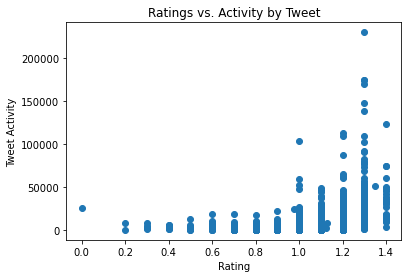

In [155]:
plt.scatter(archive_dogs['rating'], archive_dogs['tweet_activity'])
plt.title('Ratings vs. Activity by Tweet')
plt.xlabel('Rating')
plt.ylabel('Tweet Activity');

Again, there appears to be a positive correlation between ratings and activity by tweet, although it does not seem to be as strong as the scatter plot by breed. I will also find the Pearson correlation coefficient, but to do that, I will need to drop any rows with missing `tweet_activity`.

In [156]:
archive_dogs_notnull = archive_dogs.dropna(subset=['tweet_activity'])

In [157]:
pearsonr(archive_dogs_notnull['rating'], archive_dogs_notnull['tweet_activity'])

(0.38489452432725135, 2.2380660269626426e-60)

As I predicted, there is a positive correlation between ratings and activity by each individual tweet. This correlation is also moderate, but not as strong as the one by breed.

<a id='conclusion'></a>
## Conclusion

A final report on this analysis can be found [here](https://github.com/evanchen13/weratedogs/blob/master/act_report.ipynb).

<a id='sources'></a>
## Sources

- [Tweepy documentation](http://docs.tweepy.org/en/v3.2.0/api.html#API)
- [How to get tweet JSON data](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id)
- [Reading and writing JSON to a file](https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/)
- [Drop rows based on certain conditions](https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/)
- [How to extract year and month](https://www.interviewqs.com/ddi_code_snippets/extract_month_year_pandas)